어쩔수 없이 아이디어에 맞춰야 한다.

본인들 성향에 맞춰서 나가면 된다.

오토인코더를 이용한 흑백 사진을 컬러로

칼라별 색상에 대한 정확한 이해가 기반이 되어야 한다.

Lab 이란 ? : L*: Lightness , a*: Red/Green Value , b*: Blue/Yellow Value
Lab 칼라는 채널별 최대값을 [0-100, +-128, +-128]로 가지고 있음

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image
from PIL import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [3]:
# 이미지 로드

train_images = np.load(".\\pfcn.npz\\train_images.npy")
train_mattes = np.load('.//pfcn.npz/train_mattes.npy')
test_images = np.load('.\\pfcn.npz\\test_images.npy')
test_mattes = np.load('.//pfcn.npz/test_mattes.npy')

In [4]:
## 흑백이미지 x값 생성
from skimage import color
train_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in train_images])
test_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in test_images])

print(train_gray_images.shape, test_gray_images.shape)

(1700, 100, 75, 1) (300, 100, 75, 1)


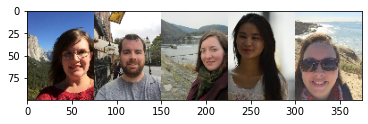

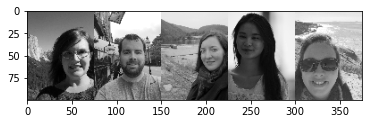

In [5]:
plt.imshow(np.hstack(train_images[:5]))
plt.show()

plt.imshow(np.hstack(train_gray_images[:5]), cmap='gray')
plt.show()

In [6]:
# input (100, 75, 1), output (100, 75, 3)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
    
def unet_color():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding="valid", output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(3, 1, activation="sigmoid")(c9)
    model = Model(inputs, outputs)
    return model

In [7]:
# unet_color() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
model = unet_color()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 75, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
model.compile(loss = "mse", optimizer="adam", metrics=["accuracy"])
hist = model.fit(train_gray_images, train_images, 
                 validation_data=(test_gray_images, test_images), 
                 epochs=50, verbose=1)

Epoch 1/50
54/54 [==============================] - 9s 68ms/step - loss: 0.0216 - accuracy: 0.6701 - val_loss: 0.0803 - val_accuracy: 0.6786
Epoch 2/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0105 - accuracy: 0.6767 - val_loss: 0.0672 - val_accuracy: 0.6892
Epoch 3/50
54/54 [==============================] - 2s 41ms/step - loss: 0.0091 - accuracy: 0.6756 - val_loss: 0.0598 - val_accuracy: 0.6892
Epoch 4/50
54/54 [==============================] - 2s 41ms/step - loss: 0.0085 - accuracy: 0.6704 - val_loss: 0.0491 - val_accuracy: 0.6481
Epoch 5/50
54/54 [==============================] - 2s 42ms/step - loss: 0.0083 - accuracy: 0.6608 - val_loss: 0.0393 - val_accuracy: 0.6392
Epoch 6/50
54/54 [==============================] - 2s 41ms/step - loss: 0.0079 - accuracy: 0.6543 - val_loss: 0.0306 - val_accuracy: 0.6113
Epoch 7/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0077 - accuracy: 0.6568 - val_loss: 0.0252 - val_accuracy: 0.6759
Epoch 8/50
54

In [9]:
## Step 6. lab 칼라 모델링
# rgb2lab을 이용하여 rgb 칼라를 lab 칼라로 바꾸는 코드를 작성하세요.
train_lab_images = np.array([color.rgb2lab(img) for img in train_images])
test_lab_images = np.array([color.rgb2lab(img) for img in test_images])

In [10]:
train_lab_images = (train_lab_images + [0, 128, 128]) / [100., 255., 255.]
test_lab_images = (test_lab_images + [0, 128, 128]) / [100., 255., 255.]

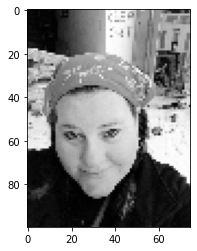

0.0 1.0
0.19397112017382181 0.8400303209378147
0.14128202093029715 0.8698299619820618


In [11]:
plt.imshow(test_lab_images[11][...,0], cmap="gray")
plt.show()     
#np.shape(test_lab_images),np.shape(test_lab_images)

print(train_lab_images[...,0].min(), train_lab_images[...,0].max())
print(train_lab_images[...,1].min(), train_lab_images[...,1].max())
print(train_lab_images[...,2].min(), train_lab_images[...,2].max())

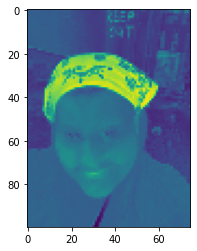

In [12]:
plt.imshow(test_lab_images[11][...,0:1],cmap='gray')
plt.imshow(test_lab_images[11][...,1:2])

In [13]:
#########################################################################################
## 출력형태가 100,75,2 여야함.
# input (100, 75, 1), output (100, 75, 2)
##########################################################################################
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
    
def unet_lab():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)
    
    u6 = Conv2DTranspose(128, 2, 2, padding="valid", output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(2, 1, activation="sigmoid")(c9)
    model = Model(inputs, outputs)
    return model

In [14]:
model2 = unet_lab()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 100, 75, 16)  160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 100, 75, 16)  64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 100, 75, 16)  0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

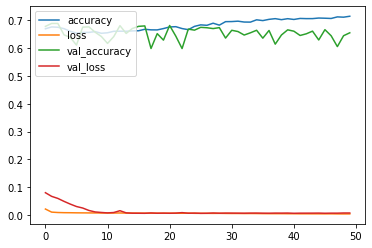

In [15]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [16]:
res = model2.predict(test_lab_images[1:2][...,0:1])

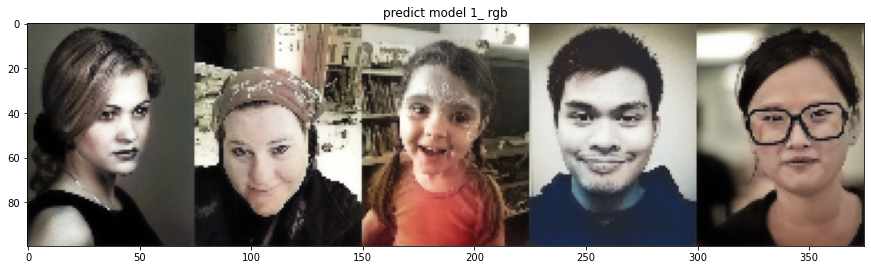

In [17]:
plt.figure(figsize=(15,5))
five1 = model.predict(test_gray_images[10:15])
plt.imshow(np.hstack(five1))
plt.title('predict model 1_ rgb')
plt.show()

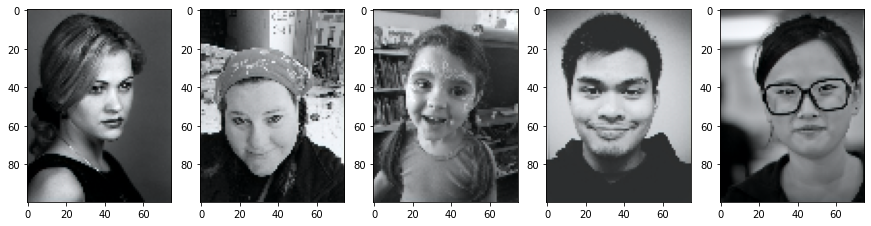

In [18]:
plt.figure(figsize=(15,5))
def l2rgb(imgArr):
    pred_ab = model2.predict(np.expand_dims(imgArr, 0))
    pred_img = np.zeros((100, 75, 3))

    pred_img[:,:,0] = imgArr.reshape((100,75))
    pred_img[:,:,1:] = pred_ab[0]
    
    pred_lab = (pred_img * [100, 255, 255]) - [0, 128, 128]
    rgb_img = color.lab2rgb(pred_lab)
    return rgb_img


for cnt,x in enumerate(range(10,15)):
    plt.subplot(1,5,cnt+1)
    plt.imshow(l2rgb(test_lab_images[x][...,0]) )

In [19]:
test_images[10].min(),test_images[10].max()

(0.0, 0.9794117647058828)

In [20]:
np.shape(test_lab_images), test_lab_images.min(),test_lab_images.max()

((300, 100, 75, 3), 0.0, 1.0)

인물사진 위주의 흑백사진을 넣어서 컬러 사진으로 변경하여 보세요

In [26]:
import glob
import cv2
from skimage.transform import resize

#aaa = resize(aa, (100,75,3))

img = cv2.imread(".//img//autumn2.jpg")
#aaa = resize(aa, (100,75,3))

test_gray_img = np.array([color.rgb2gray(img).reshape((100, 75, 1))])

test_img = np.array([color.rgb2lab(img)])
test_imgs = (test_gray_img + [0, 128, 128]) / [100., 255., 255.]
test_img_re = test_imgs.copy()

np.shape(test_img_re), type(test_img_re), np.shape(test_gray_img[0]), type(test_gray_img)

#result_1 = model.predict(test_gray_img[1:2][...,0:1])
#result_2 = model2.predict(test_img_re[1:2][...,0:1])


np.shape(test_gray_img[1:2][...,0:1]), np.shape(test_img_re[1:2][...,0:1])

((0, 100, 75, 1), (0, 100, 75, 1))